<a href="https://colab.research.google.com/github/ujjawalsingh10/Image-Generation/blob/main/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Data Preparation


In [18]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [19]:
mnist_digits = np.concatenate([x_train, x_test], axis = 0)


In [40]:
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

In [41]:
len(mnist_digits)

70000

In [42]:
mnist_digits.shape

(70000, 28, 28, 1)

In [43]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [46]:
BATCH_SIZE = 128,
LATENT_DIM = 2

In [45]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Modelling

## Sampling

In [62]:
class Sampling(Layer):

  def call(self, inputs):
    mean, log_var = inputs

    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## Encoder

In [63]:
encoder_inputs = Input(shape = (28, 28, 1))

x = Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same')(encoder_inputs)
x = Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)

x = Flatten()(x)
x = Dense(16, activation = 'relu')(x)

mean = Dense(LATENT_DIM, )(x)
log_var = Dense(LATENT_DIM, )(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name = 'encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_6[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_7[0][0]']               
                                                                                            

# Decoder

In [64]:
latent_inputs = Input(shape = (LATENT_DIM, ))

x = Dense(7*7*64, activation = 'relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(32, 3, activation = 'relu', strides = 2, padding = 'same')(x)

decoder_output = Conv2DTranspose(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder_model = Model(latent_inputs, decoder_output, name = 'decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

## Overall VAE Model

In [65]:
vae_input = Input(shape = (28,28, 1), name = 'vae_input')
z, _, _ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name = 'vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


### Training

In [66]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 30

In [75]:
def custom_loss(y_true, y_pred, mean, log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2)))
  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1 - tf.math.square(mean) - tf.math.exp(log_var)), axis = 1))
  return loss_rec + loss_reg

  # def custom_loss(y_true,y_pred,mean,log_var):

  # loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  # loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  # return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [76]:
def training_block(x_batch):
  with tf.GradientTape() as recoder:
    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  partial_derivatives = recoder.gradient(loss, vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [77]:
def GAN(epochs):
  for epoch in range(1, epochs+1):
    print(f'Training for Epoch: {epoch}')

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete !!')

In [78]:
GAN(EPOCHS)

Training for Epoch: 1


Training Loss is:  tf.Tensor(184.31143, shape=(), dtype=float32)
Training for Epoch: 2
Training Loss is:  tf.Tensor(167.13286, shape=(), dtype=float32)
Training for Epoch: 3
Training Loss is:  tf.Tensor(160.27672, shape=(), dtype=float32)
Training for Epoch: 4
Training Loss is:  tf.Tensor(165.423, shape=(), dtype=float32)
Training for Epoch: 5
Training Loss is:  tf.Tensor(158.09363, shape=(), dtype=float32)
Training for Epoch: 6
Training Loss is:  tf.Tensor(154.71515, shape=(), dtype=float32)
Training for Epoch: 7
Training Loss is:  tf.Tensor(155.5878, shape=(), dtype=float32)
Training for Epoch: 8
Training Loss is:  tf.Tensor(151.23756, shape=(), dtype=float32)
Training for Epoch: 9
Training Loss is:  tf.Tensor(159.20227, shape=(), dtype=float32)
Training for Epoch: 10
Training Loss is:  tf.Tensor(147.65015, shape=(), dtype=float32)
Training for Epoch: 11
Training Loss is:  tf.Tensor(151.43294, shape=(), dtype=float32)
Training for Epoch: 12
Training Loss is:  tf.Tensor(151.12172, sha

### Testing

In [82]:
scale = 1
n = 16

In [83]:
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

In [84]:
print(grid_x, grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 18ms/step


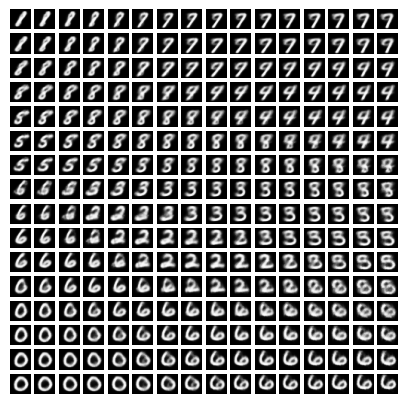

In [88]:
plt.figure(figsize = (5,5))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])
    out = vae.layers[2].predict(input)[0][..., 0] ### Using the decoder layer from the model, 0 is inputlayer, 1 is encoder and 2 is decoder
    plt.imshow(out, cmap = 'Greys_r')
    plt.axis('off')
    k+=1

In [89]:
print(vae.layers[2].predict(tf.constant([[-1,-1]]))[0][...,0].shape)

1/1 [==============================] - 0s 105ms/step
(28, 28)
